# 主成分分析
Principle Component Analysis
- 非监督学习算法
- 主要用于数据降维
- 通过降维: 提高速度, 便于发现人类理解的特征
- 应用: 降噪, 可视化, 节省运算时间
- 从高维降到低维, 会丢失信息, 丢失的信息可能是噪音

In [168]:
import numpy as np
import matplotlib.pyplot as plt

X = np.empty((100, 2))
X[:,0] = np.random.uniform(0., 100., size=100)
X[:,1] = 0.75 * X[:,0] + 3. + np.random.normal(0., 10., size=100)

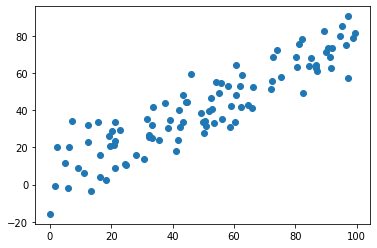

In [169]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [170]:
np.mean(X, axis=0)

array([50.13674225, 41.17588288])

In [171]:
# demean
def demean(X):
    # return X - np.array([np.mean(X[:,i]) for i in range(X.shape[1])])
    return X - np.mean(X, axis=0)

In [172]:
X_demean = demean(X)

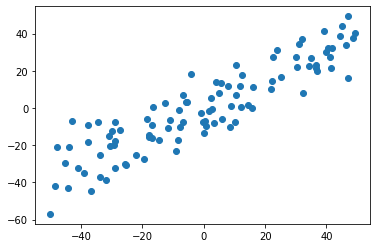

In [173]:
plt.scatter(X_demean[:,0], X_demean[:,1])
plt.show()

## 梯度上升法

In [174]:
# 求目标函数的值, 即方差
def f(w, X):
    return np.sum((X.dot(w)**2)) / len(X)

In [175]:
# 目标函数的导数
def df_math(w, X):
    return X.T.dot(X.dot(w)) * 2. / len(X)

In [176]:
def df_debug(w, X, epsilon=0.0001): # w是方向向量, 长度为1, 所以epsilon也要小
    res = np.empty(len(w))
    for i in range(len(w)):
        w_1 = w.copy()
        w_1[i] += epsilon
        w_2 = w.copy()
        w_2[i] -= epsilon
        res[i] = (f(w_1, X) - f(w_2, X)) / (2 * epsilon)
    return res

In [177]:
# 将w变为单位向量
def direction(w): 
    return w / np.linalg.norm(w) # 除以模长
    
def gradient_ascent(df, X, initial_w, eta, n_iters=1e4, epsilon=1e-8):
    w = direction(initial_w) # 用户传进来的可能没有向量化
    cur_iter = 0
    
    while cur_iter < n_iters:
        gradient = df(w, X)
        last_w = w
        w = w + eta * gradient # 梯度上升, 所以是加导数
        w = direction(w) # !!每次求一个单位方向, 因为在求数学公式的时候是吧w作为单位向量的

        if(abs(f(w, X) - f(last_w, X)) < epsilon):
            break

        cur_iter += 1
    return w

In [178]:
initial_w = np.random.random(X.shape[1]) # !!不能用0向量开始, 不然求导后依然是0, 梯度不会变
initial_w

array([0.55281877, 0.34166995])

In [179]:
eta = 0.001

In [180]:
# !!不能使用StandardScaler标准化数据, 因为均值方差归一化后的数据方差是1
# 标准化到这里只进行了一半, 均值已经归零, 但是方差不用归一

In [181]:
gradient_ascent(df_debug, X_demean, initial_w, eta)

array([0.7816522 , 0.62371455])

In [182]:
gradient_ascent(df_math, X_demean, initial_w, eta)

array([0.7816522 , 0.62371455])

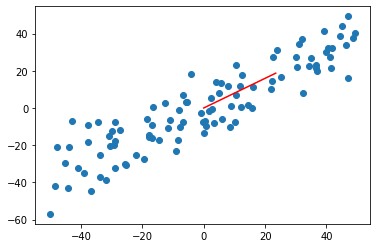

In [183]:
w = gradient_ascent(df_math, X_demean, initial_w, eta)

plt.scatter(X_demean[:,0], X_demean[:,1])
plt.plot([0, w[0]*30], [0, w[1]*30], color='r') # w太短, 所以*30
plt.show()

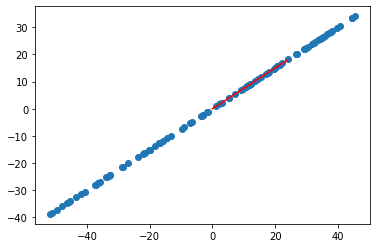

array([0.80000025, 0.59999967])

In [184]:
# 验证w轴的正确性
X2 = np.empty((100, 2))
X2[:,0] = np.random.uniform(0., 100., size=100)
X2[:,1] = 0.75 * X2[:,0] + 3. # 不加噪音

X2_demean = demean(X2)
w2 = gradient_ascent(df_math, X2_demean, initial_w, eta)
plt.scatter(X2_demean[:,0], X2_demean[:,1])
plt.plot([0, w2[0]*30], [0, w2[1]*30], color='r')
plt.show()
w2 # 

## 求数据的n个主成分
第一个轴的方差是最大的, 第二个轴次之, 第三个再次之    
有第一个主成分后, 求下一个主成分就是将数据在第一个主成分上的分量去掉      

In [185]:
# 与上面求第一主成分同, 只有小改动
def f(w, X):
    return np.sum((X.dot(w)**2)) / len(X)
def df(w, X):
    return X.T.dot(X.dot(w)) * 2. / len(X)
def direction(w): 
    return w / np.linalg.norm(w)
def first_component(X, initial_w, eta, n_iters=1e4, epsilon=1e-8):
    w = direction(initial_w) # 用户传进来的可能没有向量化
    cur_iter = 0
    
    while cur_iter < n_iters:
        gradient = df(w, X)
        last_w = w
        w = w + eta * gradient # 梯度上升, 所以是加导数
        w = direction(w) # !!每次求一个单位方向, 因为在求数学公式的时候是吧w作为单位向量的

        if(abs(f(w, X) - f(last_w, X)) < epsilon):
            break

        cur_iter += 1
    return w

In [186]:
initial_w = np.random.random(X.shape[1])
eta = 0.01
w = first_component(X, initial_w, eta) # 第一主成分
w

array([0.77477393, 0.63223837])

In [187]:
"""
X2 = np.empty(X.shape) # 第二主成分
for i in range(len(X)):
    X2[i] = X[i] - X[i].dot(w) * w # X[i].dot(w) 得映射到w上的向量的长度, 再乘w得映射到w上的向量(X_project)
    # X已经demean, X2不用demean了
"""
# 向量化写法 0.626 0.500
X2 = X - X.dot(w).reshape(-1, 1) * w # X.dot(w)之后是一维向量, 不能直接乘w向量, 要reshape成m*1的矩阵, 乘w后变m*2矩阵

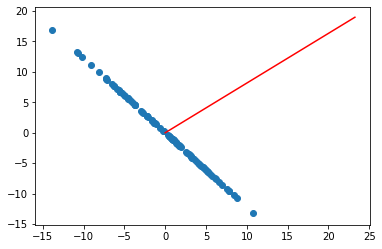

-4.440892098500626e-15


In [188]:
plt.plot([0, w[0]*30], [0, w[1]*30], color='r')
plt.scatter(X2[:, 0], X2[:, 1])
plt.show() # 所有数据去除掉第一主成分之后, 都分布在垂直于第一主成分的那条轴的直线上
print(X2[2].dot(w)) # 为0, 垂直

In [189]:
w2 = first_component(X2, initial_w, eta)
w2

array([-0.63223561,  0.77477618])

In [190]:
w.dot(w2) # 垂直

3.560011912540073e-06

In [191]:
def first_n_components(n, X, eta=0.01, n_iters=1e4, epsilon=1e-8):
    X_pca = X.copy() # 保护好原数据X
    X_pca = demean(X_pca)
    res = [] # 前n个主成分
    for i in range(n):
        initial_w = np.random.random(X_pca.shape[1])
        w = first_component(X_pca, initial_w, eta)
        res.append(w)
        
        X_pca = X_pca - X_pca.dot(w).reshape(-1, 1) * w # X_pca 减去上一次主成分
        
    return res

In [192]:
first_n_components(2, X)

[array([0.78165193, 0.62371489]), array([-0.62371244,  0.78165388])]

## 使用自己封装的PCA

In [193]:
X = np.empty((100, 2))
X[:,0] = np.random.uniform(0., 100., size=100)
X[:,1] = 0.75 * X[:,0] + 3. + np.random.normal(0., 10., size=100)

In [194]:
from ILML.PCA import PCA

pca = PCA(n_components=1)
pca.fit(X)

PCA(n_components=1

In [195]:
pca.components_ #两个坐标轴的方向

array([[0.79354499, 0.60851159]])

In [196]:
X_reduction = pca.transform(X)
X_reduction.shape

(100, 1)

In [197]:
X_restore = pca.inverse_transform(X_reduction)
X_restore.shape

(100, 2)

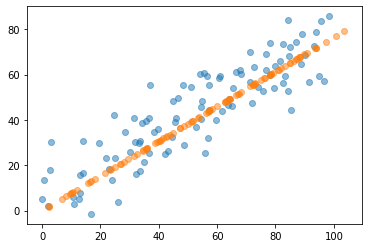

In [198]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(X_restore[:, 0], X_restore[:, 1], alpha=0.5)
plt.show()
# 降维之后再恢复, 信息丢失. 只是在高维的空间表示低维的点而已

# scikit-learn中的PCA

In [199]:
from sklearn.decomposition import PCA

In [200]:
pca = PCA(n_components=1)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [201]:
pca.components_

array([[-0.79354484, -0.60851179]])

In [202]:
X_reduction = pca.transform(X)
X_reduction.shape

(100, 1)

In [203]:
X_restore = pca.inverse_transform(X_reduction)
X_restore.shape

(100, 2)

# 实战

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [205]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [206]:
from sklearn.neighbors import KNeighborsClassifier

In [207]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [208]:
knn_clf.score(X_test, y_test)

0.9866666666666667

In [209]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_reduction, y_train)
knn_clf.score(X_test_reduction, y_test) # 速度快了, 精度低了

0.6066666666666667

In [210]:
y

array([0, 1, 2, ..., 8, 9, 8])

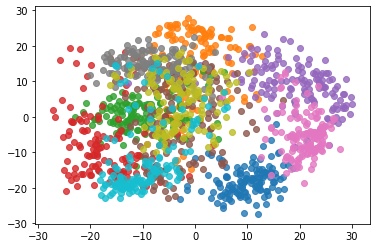

In [211]:
for i in range(10):
    plt.scatter(X_train_reduction[y_train==i,0], X_train_reduction[y_train==i,1], alpha=0.8)
plt.show()

In [212]:
pca.explained_variance_ratio_ # 两个轴能多大程度地解释原来数据的反差(百分比), 如果和原来的轴数一样则为100%

array([0.14566817, 0.13735469])

In [213]:
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)
pca.explained_variance_ratio_ # 小的可以丢掉, 说明重要程度低

array([1.45668166e-01, 1.37354688e-01, 1.17777287e-01, 8.49968861e-02,
       5.86018996e-02, 5.11542945e-02, 4.26605279e-02, 3.60119663e-02,
       3.41105814e-02, 3.05407804e-02, 2.42337671e-02, 2.28700570e-02,
       1.80304649e-02, 1.79346003e-02, 1.45798298e-02, 1.42044841e-02,
       1.29961033e-02, 1.26617002e-02, 1.01728635e-02, 9.09314698e-03,
       8.85220461e-03, 7.73828332e-03, 7.60516219e-03, 7.11864860e-03,
       6.85977267e-03, 5.76411920e-03, 5.71688020e-03, 5.08255707e-03,
       4.89020776e-03, 4.34888085e-03, 3.72917505e-03, 3.57755036e-03,
       3.26989470e-03, 3.14917937e-03, 3.09269839e-03, 2.87619649e-03,
       2.50362666e-03, 2.25417403e-03, 2.20030857e-03, 1.98028746e-03,
       1.88195578e-03, 1.52769283e-03, 1.42823692e-03, 1.38003340e-03,
       1.17572392e-03, 1.07377463e-03, 9.55152460e-04, 9.00017642e-04,
       5.79162563e-04, 3.82793717e-04, 2.38328586e-04, 8.40132221e-05,
       5.60545588e-05, 5.48538930e-05, 1.08077650e-05, 4.01354717e-06,
      

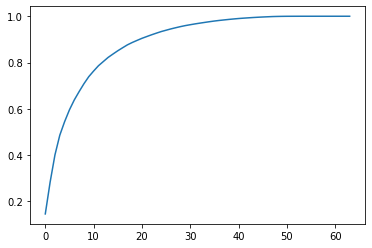

In [214]:
plt.plot([i for i in range(X_train.shape[1])], 
        [np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(X_train.shape[1])])
plt.show()

In [215]:
pca = PCA(0.95) # 要解释原数据95以上的方差
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [216]:
pca.n_components_

28

In [217]:
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_reduction, y_train)
knn_clf.score(X_test_reduction, y_test)

0.98